<h1>The Shakespeare Training Data</h1>

In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
%pip install tiktoken

--2023-06-05 02:50:40--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.006s  

2023-06-05 02:50:40 (165 MB/s) - ‘input.txt.1’ saved [1115394/1115394]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h2>Char encode</h2>

In [ ]:
input_file = open('input.txt', 'r', encoding = 'utf-8')
text = input_file.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
# print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [ ]:
# Tokenization - Look into tokenization using words and like-words -> sentencepiece? tiktoken?
# look up tables of characters for now :D
stoi = { ch : i for i, ch in enumerate(chars) } # dictionary of string keys and int values using list comprehension
itos = { i : ch for i, ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# print(encode("hii there"))
# print(decode([46, 47, 47, 1, 58, 46, 43, 56, 43]))

# data = torch.tensor(encode("hii there"), dtype = torch.int64)
# print(data.shape, data.dtype)

<h2>Tiktoken</h2>

In [4]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")

input_file = open('input.txt', 'r', encoding = 'utf-8')
text = input_file.read()

vocab_size = enc.n_vocab
print(vocab_size)

100277


In [5]:
def encode(s):
  return enc.encode(s)

def decode(l):
  return enc.decode(l)

<h2>Train and Validation Separation</h2>

In [6]:
data = torch.tensor(encode(text), dtype = torch.int64)
print(data.shape)
# print(data[:1000])

n = int(.9 * len(data)) # witholding 90% of the data for training
train_data = data[:n]
val_data = data[n:] # 10% of the data becomes validation data

# block_size = 8
# print(train_data[:block_size + 1])

# x = train_data[:block_size]
# y = train_data[1 : block_size + 1]

# for t in range(block_size):
#   context = x[:t + 1]
#   target = y[t]
#   print(f"When input is {context}: {target}")

In [7]:
def get_batch(split):
  #generate small bacth of data input x and target y
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,)) # generates an array of random numbers with the shape (batch_size,) and max range len(data) - block_size

  x = torch.stack([data[i : i + block_size] for i in ix])
  y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])

  x, y = x.to(device), y.to(device) # sending to the current device

  return x, y

# xb, yb = get_batch('train')
# print('inputs:')
# print(xb.shape, xb)
# print('targets:')
# print(yb.shape, yb)

<h1>The Bigram Model</h1>

In [ ]:
import torch.nn as nn
from torch.nn import functional

In [ ]:
class BigramLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets = None):
    # idx and targets are both (B, T) tensor of integers
    logits = self.token_embedding_table(idx) # (B, T, C)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B * T, C)
      targets = targets.view(B * T) # could also use -1 because pytorch will guess

      loss = functional.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array in the current context
    for _ in range(max_new_tokens):
      # predictions
      logits, _ = self(idx)
      # focus in on lost step
      logits = logits[:,-1,:] # becomes (B, C)
      # apply soft max to get probabilities
      probs = functional.softmax(logits, dim = -1) # (B, C)
      # sample
      idx_next = torch.multinomial(probs, num_samples = 1) # (B, 1)
      # append sampled index to the sequence
      idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
    return idx

In [ ]:
# create the bigram model
m = BigramLanguageModel().half()
# logits, loss = m(xb, yb)
# print(logits.shape)
# print(loss)

# idx = torch.zeros((1, 1), dtype = torch.int64)
# print(decode(m.generate(idx, max_new_tokens = 100)[0].tolist()))

# create an optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

# training
batch_size = 32

for step in range(2000):
  xb, yb = get_batch('train')

  #evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none = True)
  loss.backward()
  optimizer.step()

print(loss.item())

In [ ]:
print(decode(m.generate(torch.zeros((1, 1), dtype = torch.int64), max_new_tokens = 500)[0].tolist()))


HESCENGe t thyshin n:
Han,':
Benhikshipobre ang!-Hetar wou
Y ald, nge'd Dre wis s. wheloond!
Wawhe, ousor h o GSSCUn m ANETo fend her O: Lowhearery therenthis; thontherithange tomour ht oouly mstalou u tou owidod

I rde.
Hon flde-cokea an ongiofothy, ptos:


AMu ais veway ll t, the arshthise tse avewror that.
RWALIICEROMan w d clanger, y gaceth.

BEEThofrsayiorghe bltoqu s th I t
Yould t ls imping, heg co wo hiveariend ve,
Whee hatoe assteo Yooloveand itingrouclll tosstheoms'ly bofantryous be w;


<h1>Example of Bag of Words<h1>

In [ ]:
# consider the example
torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)

# we want x[b, t] = mean_{i <= t} x[b, i]
xbow = torch.zeros((B, T, C)) # bow is bag of words, we're already familiar with this concept
for b in range(B):
  for t in range(T):
    xprev = x[b, :t + 1] # (t, C)
    xbow[b, t] = torch.mean(xprev, 0)

# this is very inefficient

In [ ]:
# we could use some linear algebra :( it always comes back
weight = torch.tril(torch.ones(T, T)) # this will make a lower triagular matix of ones
weight = weight / torch.sum(weight, 1, keepdim = True) # we can now add up the row (that is what the one is for) and keep the dimension of the matrix and do a element by element division

# @ is matrix multiplication
xbow2 = weight @ x # (B, T, T) @ (B, T, C) -> (B, T, C)

In [ ]:
# we want to use softmax in order to count for affinities later on
tril = torch.tril(torch.ones(T, T))
weight = torch.zeros((T, T))
weight = weight.masked_fill(tril == 0, float('-inf'))
weight = functional.softmax(weight, dim = -1)
xbow3 = weight @ x

<h1>Batch Normilization Example<h1>

In [ ]:
class BatchNorm:
  def __init__(self, dim, eps = 1e-5, momentum = .1):
    self.eps = eps
    self.momentum = momentum # for batch norm
    self.training = True # for batch norm
    # parameters (trained during backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained running momemntum update)
    self.running_mean = torch.zeros(dim) # for batch norm
    self.running_var = torch.ones(dim) # for batch norm

  # batch norm call
  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim = True) # batch mean
      xvar = x.var(0, keepdim = True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

<h1>Self-Attention Example</h1>

- Attention is a **communication mechanism**. Essentially nodes in a directed graph and aggregate their information in a sum: data dependent.
- There is no notion of space. We need to add it.
- The batches never "talk to each other"
- The attention block will never communivate forward, but we could add that in for something like "sentiment analysis"
  - encoder vs decoder blocks essentially
- "self-attention" all come from the same location, but if there are "cross-attention" allows for a separate set of nodes we want context from
- "scaled" attention also divides by 1/sqrt(head_size) which essentially subdues the variance so that softmax will be less extreme at initialization

In [ ]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

# single head of self attention
head_size = 16
key = nn.Linear(C, head_size, bias = False)
query = nn.Linear(C, head_size, bias = False)
value = nn.Linear(C, head_size, bias = False)
k = key(x) # (B, T, head_size)
q = query(x) # (B, T, head_size)

weight = q @ k.transpose(-2, -1) * head_size**-.5 # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weight = torch.zeros((T, T))
weight = weight.masked_fill(tril == 0, float('-inf'))
weight = functional.softmax(weight, dim = -1)

# normally out = weight @ x but we want x to be "private" to each head

v = value(x)
out = weight @ v

<h1>GPT Model<h1>

In [8]:
batch_size = 64 # how many parallel sequences
block_size = 512 # maximum context
max_iterations = 500
eval_interval = 1000
learning_rate = 3e-4
eval_iterations = 1000
n_embed = 384 # number of embeddings
n_layers = 6
n_head = 6
dropout = 0.4

In [9]:
import torch.nn as nn
from torch.nn import functional

<h2>Not memory efficient</h2>

In [ ]:
class Head(nn.Module):
  # one head of self attention
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embed, head_size, bias = False)
    self.query = nn.Linear(n_embed, head_size, bias = False)
    self.value = nn.Linear(n_embed, head_size, bias = False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout) # adding drop out to prevent overfitting

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)
    q = self.query(x)
    # compute attention scores
    weight = q @ k.transpose(-2, -1) * C**-.5 # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
    weight = weight.masked_fill(self.tril[:T][:T] == 0, float('-inf')) # (B, T, T)
    weight = functional.softmax(weight, dim = -1)
    weight = self.dropout(weight)
    # perform the weighted aggregation
    v = self.value(x) # (B, T, C)
    out = weight @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

    return out

In [ ]:
class MultiHead(nn.Module):
  # the hydra of self attention
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embed, n_embed) # we need projection layers to finalize the projection onto the residual pathway
    self.dropout = nn.Dropout(dropout) # adding drop out to prevent overfitting

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim = - 1)
    out = self.dropout(self.proj(out))
    return out

In [ ]:
class FeedForward(nn.Module):
  # simple linear layer
  def __init__(self, n_embed):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embed, 4 * n_embed), # adding more computation by multiplying by 4
        nn.ReLU(),
    )
    self.proj = nn.Linear(4 * n_embed, n_embed) # we need projection layers to finalize the projection onto the residual pathway
    self.dropout = nn.Dropout(dropout) # adding drop out to prevent overfitting

  def forward(self, x):
    out = self.net(x)
    out = self.dropout(self.proj(out))
    return out

In [ ]:
class Block(nn.Module):
  def __init__(self, n_embed, n_head):
    super().__init__()
    head_size = n_embed // n_head # we want the concat to equal what one head would've looked like so we need to divide it up
    self.sa = MultiHead(n_head, head_size) # self attention head list
    self.ffwd = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)

  def forward(self, x):
    # we want to add x to itself to apply some residual pathway which will make the blocks "slowly come online"
    x = x + self.sa(self.ln1(x)) # apply self attention (B, T, C)
    x = x + self.ffwd(self.ln2(x)) # (B, T, C)
    return x

In [ ]:
class GPTModel(nn.Module):
  def __init__(self):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
    self.position_embedding_table = nn.Embedding(block_size, n_embed) # positional embedding to add the spatial feature to attention
    self.blocks = nn.Sequential(*[Block(n_embed, n_head = n_head) for _ in range(n_layers)]) # asterisk here unpacks the list
    self.lnf = nn.LayerNorm(n_embed) # final layer norm
    self.lm_head = nn.Linear(n_embed, vocab_size) # language model head

  def forward(self, idx, targets = None):
    B, T = idx.shape
    # idx and targets are both (B, T) tensor of integers
    token_embeddings = self.token_embedding_table(idx) # (B, T, C)
    position_embeddings = self.position_embedding_table(torch.arange(T, device = device)) # (T, C)
    x = token_embeddings + position_embeddings # (B, T, C)
    x = self.lnf(self.blocks(x)) # apply alternating self attention and computation (B, T, C) then layer norm
    logits = self.lm_head(x) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B * T, C)
      targets = targets.view(B * T) # could also use -1 because pytorch will guess

      loss = functional.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array in the current context
    for _ in range(max_new_tokens):
      # crop context
      idx_cond = idx[:, -block_size:]
      # predictions
      logits, _ = self(idx_cond)
      # focus in on lost step
      logits = logits[:,-1,:] # becomes (B, C)
      # apply soft max to get probabilities
      probs = functional.softmax(logits, dim = -1) # (B, C)
      # sample
      idx_next = torch.multinomial(probs, num_samples = 1) # (B, 1)
      # append sampled index to the sequence
      idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
    return idx

In [ ]:
# create the bigram model
m = GPTModel()
m = m.to(device) # sending the model to the device
# logits, loss = m(xb, yb)
# print(logits.shape)
# print(loss)

# idx = torch.zeros((1, 1), dtype = torch.int64)
# print(decode(m.generate(idx, max_new_tokens = 100)[0].tolist()))

In [ ]:
# create an optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr = learning_rate)
for step in range(max_iterations):
  xb, yb = get_batch('train')

  #evaluate the loss
  _, train_loss = m(xb, yb)
  optimizer.zero_grad(set_to_none = True)
  train_loss.backward()
  optimizer.step()

  if step % eval_interval == 0:
    for eval in range(eval_iterations):
      xb, yb = get_batch('val')
      _, eval_loss = m(xb, yb)

    print(f"Step {step}: training loss = {train_loss.detach()}, evaluation loss {eval_loss.detach()}")

<h2>Memory Efficient</h2>

In [10]:
from torch import autocast

In [11]:
class CastedHead(nn.Module):
  # one head of self attention
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embed, head_size, bias = False)
    self.query = nn.Linear(n_embed, head_size, bias = False)
    self.value = nn.Linear(n_embed, head_size, bias = False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout) # adding drop out to prevent overfitting

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)
    q = self.query(x)
    # compute attention scores
    weight = q @ k.transpose(-2, -1) * C**-.5 # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
    weight = weight.masked_fill(self.tril[:T][:T] == 0, float('-inf')) # (B, T, T)
    with autocast(device):
      weight = functional.softmax(weight, dim = -1)
      weight = self.dropout(weight)
      # perform the weighted aggregation
      v = self.value(x) # (B, T, C)
      out = weight @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

    return out

In [12]:
class CastedMultiHead(nn.Module):
  # the hydra of self attention
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([CastedHead(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embed, n_embed) # we need projection layers to finalize the projection onto the residual pathway
    self.dropout = nn.Dropout(dropout) # adding drop out to prevent overfitting

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim = - 1)
    out = self.dropout(self.proj(out))
    return out

In [13]:
from torch.utils.checkpoint import checkpoint
class CheckPointed(nn.Sequential): # using checkpointed backprop for memory efficiency
  def forward(self, *args):
    return checkpoint(super().forward, *args)

In [14]:
class CheckPointedFeedForward(nn.Module):
  # simple linear layer
  def __init__(self, n_embed):
    super().__init__()
    self.net = CheckPointed(
      nn.Linear(n_embed, 4 * n_embed), # adding more computation by multiplying by 4
      nn.ReLU(),
      nn.Linear(4 * n_embed, n_embed), # we need projection layers to finalize the projection onto the residual pathway
      nn.Dropout(dropout), # adding drop out to prevent overfitting
    )

  def forward(self, x):
    out = self.net(x)
    return out

In [15]:
class CastedCheckPointedBlock(nn.Module):
  def __init__(self, n_embed, n_head):
    super().__init__()
    head_size = n_embed // n_head # we want the concat to equal what one head would've looked like so we need to divide it up
    self.sa = CastedMultiHead(n_head, head_size) # self attention head list
    self.ffwd = CheckPointedFeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)

  def forward(self, x):
    # we want to add x to itself to apply some residual pathway which will make the blocks "slowly come online"
    x = x + self.sa(self.ln1(x)) # apply self attention (B, T, C)
    x = x + self.ffwd(self.ln2(x)) # (B, T, C)
    return x

In [16]:
class CastedCheckPointedGPTModel(nn.Module):
  def __init__(self):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
    self.position_embedding_table = nn.Embedding(block_size, n_embed) # positional embedding to add the spatial feature to attention
    self.blocks = CheckPointed(*[CastedCheckPointedBlock(n_embed, n_head = n_head) for _ in range(n_layers)]) # asterisk here unpacks the list
    self.lnf = nn.LayerNorm(n_embed) # final layer norm
    self.lm_head = nn.Linear(n_embed, vocab_size) # language model head

  def forward(self, idx, targets = None):
    B, T = idx.shape
    # idx and targets are both (B, T) tensor of integers
    token_embeddings = self.token_embedding_table(idx) # (B, T, C)
    position_embeddings = self.position_embedding_table(torch.arange(T, device = device)) # (T, C)
    x = token_embeddings + position_embeddings # (B, T, C)
    x = self.lnf(self.blocks(x)) # apply alternating self attention and computation (B, T, C) then layer norm
    logits = self.lm_head(x) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B * T, C)
      targets = targets.view(B * T) # could also use -1 because pytorch will guess

      loss = functional.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array in the current context
    for _ in range(max_new_tokens):
      # crop context
      idx_cond = idx[:, -block_size:]
      # predictions
      logits, _ = self(idx_cond)
      # focus in on lost step
      logits = logits[:,-1,:] # becomes (B, C)
      # apply soft max to get probabilities
      with autocast(device):
        probs = functional.softmax(logits, dim = -1) # (B, C)
      # sample
      idx_next = torch.multinomial(probs, num_samples = 1) # (B, 1)
      # append sampled index to the sequence
      idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
    return idx

In [17]:
# create the bigram model
m = CastedCheckPointedGPTModel().half()
m = m.to(device) # sending the model to the device
# logits, loss = m(xb, yb)
# print(logits.shape)
# print(loss)

# idx = torch.zeros((1, 1), dtype = torch.int64)
# print(decode(m.generate(idx, max_new_tokens = 100)[0].tolist()))

In [18]:
batch_acc = batch_size
batch_size = 16
accumulation_step = int(batch_acc / batch_size)

In [19]:
%pip install bitsandbytes==0.35.0 # using bitsandbytes 0.35.0 because there is a bug with 0.36.0 where values become NAN
import bitsandbytes as bnb

# create a memory efficient optimizer
optimizer = bnb.optim.AdamW8bit(m.parameters(), lr = learning_rate)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:105: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-t4-s-1t7tltk19u9ik -

In [20]:
train_losses = []
eval_losses = []

In [21]:
for step in range(max_iterations * accumulation_step):
  xb, yb = get_batch('train')

  #evaluate the loss
  _, train_loss = m(xb, yb)
  train_loss.backward()
  train_losses.append(train_loss.item())
  
  if step % accumulation_step == accumulation_step - 1:
    optimizer.step()
    optimizer.zero_grad(set_to_none = True)

  if step % eval_interval == eval_interval - 1:
    for eval in range(eval_iterations):
      xb, yb = get_batch('val')
      _, eval_loss = m(xb, yb)
      eval_losses.append(eval_loss.item())

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


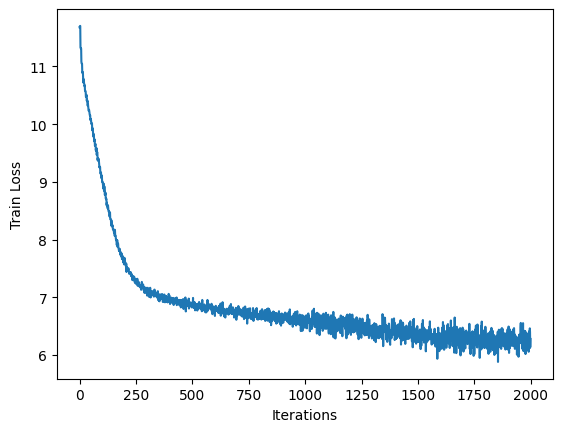

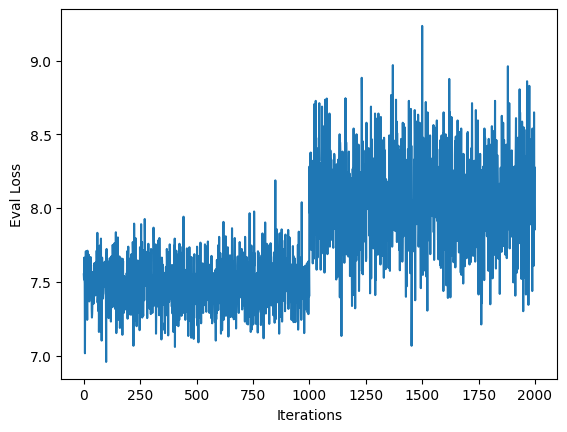

In [23]:
import matplotlib.pyplot as plt

plt.xlabel("Iterations")
plt.ylabel("Train Loss")
plt.plot([loss for loss in train_losses])
plt.show()

plt.xlabel("Iterations")
plt.ylabel("Eval Loss")
plt.plot([loss for loss in eval_losses])
plt.show()

In [24]:
print(decode(m.generate(torch.zeros((1, 512), dtype = torch.int64, device = device), max_new_tokens = 500)[0].tolist()))

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!esOM triumph.

 bandsello is heirsing pretty
RI conj own pur your of noble'd hire weakness brief! yielding praisesiled
 breathe; this powers comes,
 here, envell to laws this it it
I allowAN gardenou and be so.

Kif?

ertved.

 guilt re answer deceived at shaltign forth,ureds. fight, this be answer her do wrongifyupt victory ent
afishment as fares rev imp cold,uc bur spent.

R straight.
ent
unt at devotion,'re character, were noseORD:
at follow'llick The slander rage me worthy himsel

<h1>The Generative Pre-trained Transformer Model</h1>
From this experience I definitely learned that my initial inferences and intuition about the model were right. My problem with implementing the model was difficult taking that intuition and applying it to machine learning since my only experiences with machine learning were deep feed forward neural networks. Eventually, I learned that feed forward models can only do so much, so I have been learning new model types and learning types.

<h2>Enhancing and Fine-tuning</h2>
Eventually, I would like to take this model type and fine-tune the model to work with conversation, which requires Reinforcement Learning and PPO. That will definitely be a task in itself, but I can't wait to learn it.

While this model was only trained on Little Shakespeare, I think that, like ChatGPT, training on a larger dataset would improve the generative capabilities.

I found that while training the model to predict the next character in a sequence, the model was mostly trying to make words. The sentences didn't make much sense, and there were many non-word sequences. When training the model with sub-word tokens the goal changes to making sentences that are common given the context. The only issue I have is size of data, since there are much less sub-words than characters, and size of model. The size of the data could contribute largely to the general ability to generate sentences, but that would require more time and a larger model, which would also require more time and resources.

<h2>Learning to be Memory Efficient</h2>
One thing I definitely needed to learn was memory efficiencey. I have almost always brute forced solutions to coding problems through my undergrad until I learned better algorithms and skills. Then the solution became to think through problems and optimize them to run more efficiently, especially after taking compilation and assembly courses. Brute forcing was no longer an option.

My only problem was I don't have any better information when it comes to machine learning, and I have already finished my undergrad. I need to read papers I barely understand and articles that explain these concepts. I would just brute force a solution with the knowledge I currently had... This made me choose to quit projects that didn't work for me anymore whether because the model's could do the task because they didn't have enough time or size to work properly, or because I didn't have the knowledge necessary to make the improvements.

I wanted to do machine learning though, so I decided to take a slower approach instead of jumping in head first into the field. Now I am able to make much more complex models using more complex tools, like Jax and Pytorch and TensorFlow.


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          